# AE353 DP3 - Star Tracker Observer and Controller

Authors: Shishir Bhatta, Aerospace Engineering Undergraduate Student at University of Illinois Urbana-Champaign
Matt Pactol, Aerospace Engineering Undergraduate Student at University of Illinois Urbana-Champaign

The purpose of this report is to create a controller for a spacecraft that has a star tracker that tracks a group of stars by keeping them in view of a camera. The star tracker is a sensor that has a camera that measures the position of each star. The position of the stars with respect to where the stars should be located in the view of the camera helps us determine the angular position and velocities of the spacecraft. There are various disturbances such as debris, that cause the spacecraft to change trajectory, and the controller should readjust the tracker to keep the stars in the view of the camera. The spacecraft moves in 3 angular directions: roll, pitch, yaw. It moves by actuating 4 reaction wheels that act as momentum exchange devices to adjust the direction the spacecraft is rotating in. In order to come up with a valid controller and observer, we used LQR and determined valid gain matrices to create a system that passed our requirements. 

Celestial Navigation is an age-old system to determine the positioning of something. By using a pre-determined positionining of celestial bodies, by comparing the positions of the bodies at the moment to where they "should" be. This method is used on our spacecraft to determine it's angular position and velocity of the spacecraft. Given a pre-determined pattern of the stars and their positions, the star tracker determines the difference between the current positioning of the star and the pre-determined positions, we can find the positions and velocities of the spacecraft. This is a common method used for small satellites. The project we have been assigned uses a similar star tracker, and we are tasked with creatign a controller and observer model for this system.  

## System Linearization and State Space Form

In [152]:
# Importing all the necessary libraries
import sympy as sym
import numpy as np
from scipy import signal
from scipy import linalg
import control
sym.init_printing()

In [153]:
def change_of_coords(v_inA, roll, pitch, yaw):
    # Get the rotation matrices from the roll, pitch, and yaw values
    cx = np.cos(roll)
    sx = np.sin(roll)
    cy = np.cos(pitch)
    sy = np.sin(pitch)
    cz = np.cos(yaw)
    sz = np.sin(yaw)
    Rx = np.array([[1., 0., 0.],
                   [0., cx, -sx],
                   [0., sx, cx]])
    Ry = np.array([[cy, 0., sy],
                   [0., 1., 0.],
                   [-sy, 0., cy]])
    Rz = np.array([[cz, -sz, 0.],
                   [sz, cz, 0.],
                   [0., 0., 1.]])

    # Combine the individual rotations into a single transform
    R_ofA_inB = Rz@Ry@Rx

    # Apply the transform the the original vector in frame A
    v_inB = R_ofA_inB @ v_inA

    # Return the same vector in frame B
    return v_inB

In [154]:
# Mass and moment of inertia of the bus
mb = 6.
Ixxb = 10.
Iyyb = 10.
Izzb = 16.

# Radius of the bus
rb = 2.2

# Mass and moment of inertia of each wheel
mw = 1.
Ixxw = 0.075
Iyyw = 0.075
Izzw = 0.125

In [155]:
# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# Define angular velocities
wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')

# Define angular velocity vector written in body coordinates
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

# Define roll, pitch, and yaw rotation matrices that describe the bus's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])

In [156]:
# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Multiply torque scalars by their directions (in each wheel's frame)
# to get the torque applied to each wheel as a vector
t1_inT1 = tau_1 * sym.Matrix([[0.],
                              [0.],
                              [1.]])
t2_inT2 = tau_2 * sym.Matrix([[0.],
                              [0.],
                              [1.]])
t3_inT3 = tau_3 * sym.Matrix([[0.],
                              [0.],
                              [1.]])
t4_inT4 = tau_4 * sym.Matrix([[0.],
                              [0.],
                              [1.]])

# Change the torque on the wheel vectors from their own body coordinates to bus coordinates
t1_inB = change_of_coords(t1_inT1, 0.,       0., 1.570796)
t2_inB = change_of_coords(t2_inT2, 2.094395, 0., 2.617994)
t3_inB = change_of_coords(t3_inT3, 2.094395, 0., 4.712389)
t4_inB = change_of_coords(t4_inT4, 2.094395, 0., 0.523599)

# Sum the torque vectors to get the total torque on the spacecraft by the wheels 
# in bus coordinates.
# We use minus because the torque on the bus is in the opposite direction as the torque
# applied to the wheels (Newton's third law)
tau_inB = -t1_inB - t2_inB - t3_inB - t4_inB
tau_inB = sym.simplify(tau_inB)
print("Torques applied to spacecraft in spacecraft-fixed coordinates:")
sym.N(tau_inB, 3)

Torques applied to spacecraft in spacecraft-fixed coordinates:


⎡-0.433⋅τ₂ + 0.866⋅τ₃ - 0.433⋅τ₄⎤
⎢                               ⎥
⎢-0.75⋅τ₂ + 1.7e-8⋅τ₃ + 0.75⋅τ₄ ⎥
⎢                               ⎥
⎣-τ₁ + 0.5⋅τ₂ + 0.5⋅τ₃ + 0.5⋅τ₄ ⎦

In [157]:
# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# Define angular velocities
wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')

# Define angular velocity vector written in body coordinates
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

# Define roll, pitch, and yaw rotation matrices that describe the bus's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])

In [158]:
# First we get the position of the center of mass of each wheel in bus coordinates
p1_inB = np.round(np.array(rb*(t1_inB/tau_1)).astype(np.float64).flatten(),6)
p2_inB = np.round(np.array(rb*(t2_inB/tau_2)).astype(np.float64).flatten(),6)
p3_inB = np.round(np.array(rb*(t3_inB/tau_3)).astype(np.float64).flatten(),6)
p4_inB = np.round(np.array(rb*(t4_inB/tau_4)).astype(np.float64).flatten(),6)
ps_inB = [p1_inB, p2_inB, p3_inB, p4_inB]

# Get the total moment of inertia
Ixx = Ixxb
Iyy = Iyyb
Izz = Izzb
for p_inB in ps_inB:
    # Get the distance from the x axis and the resultant point inertia
    dx = np.linalg.norm(p_inB[1:])
    ixx = mw * dx**2
    Ixx = Ixx + ixx
    
    # Get the distance from the y axis and the resultant point inertia
    dy = np.linalg.norm(p_inB[0:3:2])
    iyy = mw * dy**2
    Iyy = Iyy + iyy
    
    # Get the distance from the z axis and the resultant point inertia
    dz = np.linalg.norm(p_inB[0:2])
    izz = mw * dz**2
    Izz = Izz + izz

# Assemble the moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])
print("Moment of inertia of spacecraft written in principal axes:")
sym.N(I_inB, 3)

Moment of inertia of spacecraft written in principal axes:


⎡23.9   0     0  ⎤
⎢                ⎥
⎢ 0    23.9   0  ⎥
⎢                ⎥
⎣ 0     0    26.9⎦

In [159]:
# Apply Euler's equation to get the time derivative of the angular velocities of the
# spacecraft in the spacecraft frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)
print("Time derivative of the angular velocities in the spacecraft-fixed frame:")
sym.N(w_inB_dot, 3)

Time derivative of the angular velocities in the spacecraft-fixed frame:


⎡      -0.124⋅ω_y⋅ω_z - 0.0181⋅τ₂ + 0.0362⋅τ₃ - 0.0181⋅τ₄       ⎤
⎢                                                               ⎥
⎢       0.124⋅ωₓ⋅ω_z - 0.0314⋅τ₂ + 7.1e-10⋅τ₃ + 0.0314⋅τ₄       ⎥
⎢                                                               ⎥
⎣-2.37e-8⋅ωₓ⋅ω_y - 0.0372⋅τ₁ + 0.0186⋅τ₂ + 0.0186⋅τ₃ + 0.0186⋅τ₄⎦

In [160]:
# Define the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Invert the transformation to get a matrix that takes body-fixed angular rates to 
# roll, pitch, and yaw rates
M_inv = sym.simplify(M.inv())

# Convert the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = sym.simplify(M_inv@w_inB)
print("Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:")
sym.N(rpy_dot,3)

Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:


⎡ωₓ + ω_y⋅sin(φ)⋅tan(θ) + ω_z⋅cos(φ)⋅tan(θ)⎤
⎢                                          ⎥
⎢         ω_y⋅cos(φ) - ω_z⋅sin(φ)          ⎥
⎢                                          ⎥
⎢         ω_y⋅sin(φ) + ω_z⋅cos(φ)          ⎥
⎢         ───────────────────────          ⎥
⎣                  cos(θ)                  ⎦

In [161]:
# Assemble the system of equations
f = sym.simplify(sym.Matrix.vstack(rpy_dot, w_inB_dot))

In [162]:
sym.N(f,3)

⎡          ωₓ + ω_y⋅sin(φ)⋅tan(θ) + ω_z⋅cos(φ)⋅tan(θ)           ⎤
⎢                                                               ⎥
⎢                    ω_y⋅cos(φ) - ω_z⋅sin(φ)                    ⎥
⎢                                                               ⎥
⎢                    ω_y⋅sin(φ) + ω_z⋅cos(φ)                    ⎥
⎢                    ───────────────────────                    ⎥
⎢                             cos(θ)                            ⎥
⎢                                                               ⎥
⎢      -0.124⋅ω_y⋅ω_z - 0.0181⋅τ₂ + 0.0362⋅τ₃ - 0.0181⋅τ₄       ⎥
⎢                                                               ⎥
⎢       0.124⋅ωₓ⋅ω_z - 0.0314⋅τ₂ + 7.1e-10⋅τ₃ + 0.0314⋅τ₄       ⎥
⎢                                                               ⎥
⎣-2.37e-8⋅ωₓ⋅ω_y - 0.0372⋅τ₁ + 0.0186⋅τ₂ + 0.0186⋅τ₃ + 0.0186⋅τ₄⎦

# State-Space Model
## Controller Dynamics
The dynamics are represented in a column vector, in which each each equation represents the dynamics of each state we are tracking. In our system, we are tracking, $\phi$ (roll), $\theta$ (pitch), $\psi$ (yaw), and the angular velocities of each angular direction $\omega_x$, $\omega_y$, $\omega_z$. The goal of this is to represent the dynamics of the system as a standard state space model.
This model is typically demonstrated as:

<center>$ \dot x = Ax + Bu $</center>

This model makes it a lot easier to tune the controller and observer systems. Although each equation is a first-order differential equation, we must linearize it since they are not linear ODEs. This can be done by taking the Jacobian of the matrices with respect to certain variables. 

The A coefficient matrix describes how the system's dynamics change from time step t, to t+1, without any other inputs. This can be derived by taking the Jacobian of the f matrix with respect to the states, which are $\phi, \theta, \psi, \omega_x, \omega_y$ and $\omega_z$. 
The B coefficient matrix describes how control inputs change the dynamics of a system from time step t, to t+1. This can be derived by taking the Jacobian of the f matrix with respect to the control inputs, which in our case is $\tau1, \tau2, \tau3, \tau4$. 

In addition to the Jacobians, we must also find the equilibrium points of the systems. The equilibrium points are values in which if our system were to reach these positions, they would remain in steady state and not deviate with no external disturbances. The method we used to find the equilibrium points was to find points in which all our states became 0s. For this reason, we selected our equilibrium points to be:


<center> \begin{bmatrix}
\phi \\
\theta \\
\psi \\
w_{x} \\
w_{y} \\
w_{z} \\
\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ \end{bmatrix} </center>
<center>\begin{bmatrix}
\tau1 \\
\tau2 \\
\tau3 \\
\tau4 \\
\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ \end{bmatrix}</center>


If achieved by the system, this means our system is in steady-state

These values are not plugged into the Jacobians to find our A and B coefficient matrices. THe A matrix should be a square matrix with dimensions 6x6, since 6 is the number of states we have. The B matrix should be a 6x4, since we have 6 states and 4 control inputs. 

We need to verify that our system is controllable, which can be achieved by creating a controllability matrix. If the rank of the matrix matches the number of states we have, then we have a controllable matrix. This can be created with the following method:

<center>$
W = \begin{bmatrix}
B & AB & A^2B & \cdots & A^nB
\end{bmatrix}
$</center>

Once we see that we have a controllable matrix, we can move on. 

In [163]:
# f = phi, theta, psi, wx, wy, wz (these are the states tracked in our spacecraft)
# angular velocities must be 0, tau values must also be 0, phi and psi can be whatever we want, cos(theta) can't be 0 because this results in 
# indeterminate system. 
phie, thetae, psie, wxe, wye, wze, tau1e, tau2e, tau3e, tau4e = 0,0,0,0,0,0,0,0,0,0
# We take the jacobian of the dynamics with respect to the states (phi, theta, psi, and their respective angular velocities) to find our A
# coefficient matrix
A = sym.lambdify((phi, theta, psi, wx_inB, wy_inB, wz_inB, tau_1, tau_2, tau_3, tau_4), f.jacobian([phi, theta, psi, wx_inB, wy_inB, wz_inB]))
# We now substitute the equilibrium values of our system to find the matrix
A_num = A(phie, thetae, psie, wxe, wye, wze, tau1e, tau2e, tau3e, tau4e)
# We find the B matrix by computing the jacobian of the system with respect to the control inputs (all 4 torques)
B = sym.lambdify((phi, theta, psi, wx_inB, wy_inB, wz_inB, tau_1, tau_2, tau_3, tau_4), f.jacobian([tau_1, tau_2, tau_3, tau_4]))
# We now substitute the equilibrium values of our system to find the matrix
B_num = B(phie, thetae, psie, wxe, wye, wze, tau1e, tau2e, tau3e, tau4e)
# As we can see, our A matrix is a 6x6 matrix and our B matrix is a 6x4 matrix, matching what we expected. 
# We can find the controllability of the matrix using the Control python library, which creates the controllability matrix for us. 
W = control.ctrb(A_num, B_num)
# The rank of the controllability matrix is 6, which matches the number of states we have. Thus we have a controllable system. 

np.linalg.matrix_rank(W) == A_num.shape[0]

True

In [164]:
# This is our A coefficient matrix
print('A: ')
sym.Matrix(A_num)

A: 


⎡0  0  0  1.0   0    0 ⎤
⎢                      ⎥
⎢0  0  0   0   1.0   0 ⎥
⎢                      ⎥
⎢0  0  0   0    0   1.0⎥
⎢                      ⎥
⎢0  0  0   0    0    0 ⎥
⎢                      ⎥
⎢0  0  0   0    0    0 ⎥
⎢                      ⎥
⎣0  0  0   0    0    0 ⎦

In [165]:
# This is our B coefficient matrix
print('B: ')
sym.Matrix(B_num)

B: 


⎡         0                    0                    0                     0   
⎢                                                                             
⎢         0                    0                    0                     0   
⎢                                                                             
⎢         0                    0                    0                     0   
⎢                                                                             
⎢         0           -0.0181063197149959   0.0362126470826273   -0.0181063305
⎢                                                                             
⎢         0           -0.0313610736839173  7.10322282429955e-10  0.03136106741
⎢                                                                             
⎣-0.0371885450450875  0.0185942692248454    0.0185942692248454   0.01859426922

      ⎤
      ⎥
      ⎥
      ⎥
      ⎥
      ⎥
787912⎥
      ⎥
17016 ⎥
      ⎥
48454 ⎦

## Observer Dynamics
The exact true state of the spacecraft $x$ is unknown, however, the measured output of the spacecraft’s sensors, $y$, is known. The output from the sensors is such that $y$ can be obtained by multiplying a particular matrix with only scalar values, $C$, by the true state $x$.

<center>$y = Cx$</center>

Theoretically, simply inverting $C$ and solving for $x$ would provide the true state, but $C$ may not be rectangular, and therefore may not be invertible. The output is continuously changing as time changes, so the real state also changes to make the equation above true at every time $t$.
The spacecraft uses a star camera to track each star in the "I" constallation. The equations the star camera sensor uses to track the 2D $y,z$ coordinates of each star from the star camera's perspective are as follows:

These equations can be used to solve for the sensor output. The equation in the first row of $g$ can be used to solve for the star tracker's $y$ coordinate output and the equation in the second row of $g$ can be used to solve for the star tracker's $z$ coordinate output.


<center>$y = g(\alpha_i, \delta_i, \phi, \theta, \psi)$</center>

The $A$ and $B$ matricies were both solved around specific equilibrium positions. The equilibrium positions that the $A$ and $B$ matrices were both solved around must be the same as the equilibrium positions used to solve for $C$. This is so that the equilibrium states, match the output at equilibrium and $y = Cx$ holds true in terms of the observer model.

Ultimately, the goal is to make the spacecraft's star tracker always point toward's the center of all the stars, such that all the stars are in frame of the star tracker camera. Therefore, all of the 8 star's with different inclination ($\alpha_i$) and declination ($\delta_i$) must be accounted for. The inclination and declination of all the stars are shown below:


In [166]:
# Create a variable for the right ascension and declination of the ith star
alpha_i, delta_i = sym.symbols('alpha_i, delta_i')
# First we import the spacecraft project's function get_star_coords
# As expected, this function returns a dictionary whose keys, 
# "alpha" and "delta", are the equitorial celestial coordinates
# of each star in the constellation
from ae353_spacecraft import get_star_coords
star_coords = get_star_coords()
star_coords

{'alpha': array([-0.06,  0.  ,  0.06,  0.  ,  0.  , -0.06,  0.  ,  0.06]),
 'delta': array([-0.09, -0.09, -0.09, -0.03,  0.03,  0.09,  0.09,  0.09])}

The matrix $C$ is found by taking the jacobian of $g$ (the observer's equations for the output) with respect to all the system's states.
8 $C$ matrices are found corresponding to the different $\alpha$ and $\delta$ of each individual star, and then all of the $C$ matrices are concatenated together to form a $(16,6)$ matrix.

In [167]:
# Calculate the DEPTH NORMALIZED cartesian coordinates of the ith star
# in the fixed world coorinates using the equitorial celestial coordinates
p_ofi_inW = sym.Matrix([[sym.cos(alpha_i)*sym.cos(delta_i)],
                        [sym.sin(alpha_i)*sym.cos(delta_i)],
                        [sym.sin(delta_i)]])
print("Depth-normalized cartesian coordinates of the ith star in world coordinates:")
p_ofi_inW

Depth-normalized cartesian coordinates of the ith star in world coordinates:


⎡cos(αᵢ)⋅cos(δᵢ)⎤
⎢               ⎥
⎢sin(αᵢ)⋅cos(δᵢ)⎥
⎢               ⎥
⎣    sin(δᵢ)    ⎦

In [168]:
# Calculate the orientation of the spacecraft using it's roll, pitch, and yaw angles
R_ofS_inW = sym.simplify(Rz @ Ry @ Rx)
print("Orientation of spacecraft in world:")
R_ofS_inW

Orientation of spacecraft in world:


⎡cos(ψ)⋅cos(θ)  sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)  sin(φ)⋅sin(ψ) + sin(θ)⋅c
⎢                                                                             
⎢sin(ψ)⋅cos(θ)  sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)  -sin(φ)⋅cos(ψ) + sin(ψ)⋅
⎢                                                                             
⎣   -sin(θ)                sin(φ)⋅cos(θ)                          cos(φ)⋅cos(θ

os(φ)⋅cos(ψ) ⎤
             ⎥
sin(θ)⋅cos(φ)⎥
             ⎥
)            ⎦

In [169]:
# Invert the orientation of the spacecraft to get a transform that takes vectors
# in world coordinates to vectors in spacecraft-fixed coordinates.
# As it turns out, the inverse of a valid rotation matrix, R, is its transpose
R_ofW_inS = R_ofS_inW.T

# Get the position of the ith star in spacecraft-fixed coordinates
p_ofi_inS = sym.simplify(R_ofW_inS @ p_ofi_inW)
print("Depth-normalized cartesian coordinates of the ith star in spacecraft-fixed coordinates:")
p_ofi_inS

Depth-normalized cartesian coordinates of the ith star in spacecraft-fixed coordinates:


⎡                     -sin(δᵢ)⋅sin(θ) + cos(δᵢ)⋅cos(θ)⋅cos(αᵢ - ψ)            
⎢                                                                             
⎢sin(δᵢ)⋅sin(φ)⋅cos(θ) + sin(φ)⋅sin(θ)⋅cos(δᵢ)⋅cos(αᵢ - ψ) + sin(αᵢ - ψ)⋅cos(δ
⎢                                                                             
⎣sin(δᵢ)⋅cos(φ)⋅cos(θ) - sin(φ)⋅sin(αᵢ - ψ)⋅cos(δᵢ) + sin(θ)⋅cos(δᵢ)⋅cos(φ)⋅co

         ⎤
         ⎥
ᵢ)⋅cos(φ)⎥
         ⎥
s(αᵢ - ψ)⎦

In [170]:
# Define the radius of the star scope
rc = 0.8/2.1

# Calculate the star scope coordinates, q,  of the ith star
# This step is why we can use depth normalized coordinates
# We divide the y,z coords by the x coord. This causes any
# constants, such as depth, to drop out.
g = sym.simplify( (1/rc) * sym.Matrix([[p_ofi_inS[1] / p_ofi_inS[0]],
                                       [p_ofi_inS[2] / p_ofi_inS[0]]]) )

g

⎡2.625⋅(sin(δᵢ)⋅sin(φ)⋅cos(θ) + sin(φ)⋅sin(θ)⋅cos(δᵢ)⋅cos(αᵢ - ψ) + sin(αᵢ - ψ
⎢─────────────────────────────────────────────────────────────────────────────
⎢                         -sin(δᵢ)⋅sin(θ) + cos(δᵢ)⋅cos(θ)⋅cos(αᵢ - ψ)        
⎢                                                                             
⎢2.625⋅(sin(δᵢ)⋅cos(φ)⋅cos(θ) - sin(φ)⋅sin(αᵢ - ψ)⋅cos(δᵢ) + sin(θ)⋅cos(δᵢ)⋅co
⎢─────────────────────────────────────────────────────────────────────────────
⎣                         -sin(δᵢ)⋅sin(θ) + cos(δᵢ)⋅cos(θ)⋅cos(αᵢ - ψ)        

)⋅cos(δᵢ)⋅cos(φ))⎤
─────────────────⎥
                 ⎥
                 ⎥
s(φ)⋅cos(αᵢ - ψ))⎥
─────────────────⎥
                 ⎦

In [171]:
#Finding C
phi, theta, psi = sym.symbols('phi, theta, psi')
star_coords = np.array([[-0.06,  0.  ,  0.06,  0.  ,  0.  , -0.06,  0.  ,  0.06], [-0.09, -0.09, -0.09, -0.03,  0.03,  0.09,  0.09,  0.09]])
phie, thetae, psie = 0,0,0
o1 = sym.lambdify((phi, theta, psi, alpha_i, delta_i),g)
for i in range(0, len(star_coords[0])):
    alpha = star_coords[0][i]
    delta = star_coords[1][i]
    if (i == 0):
        C_num = sym.lambdify((phi, theta, psi, alpha_i, delta_i), g.jacobian([phi, theta, psi, wx_inB, wy_inB, wz_inB]))
        C = C_num(phie, thetae, psie, alpha, delta)
    else:
        C = np.concatenate([C, C_num(phie, thetae, psie, alpha, delta)])
print('C: ')
sym.Matrix(C)

C: 


⎡-0.237316990961119   0.0142561309219474    -2.63447272635414   0  0  0⎤
⎢                                                                      ⎥
⎢ 0.157689272557155    2.64645499207575    -0.0142561309219474  0  0  0⎥
⎢                                                                      ⎥
⎢-0.236889948513187            0                 -2.625         0  0  0⎥
⎢                                                                      ⎥
⎢         0            2.64637784674536             0           0  0  0⎥
⎢                                                                      ⎥
⎢-0.237316990961119   -0.0142561309219474   -2.63447272635414   0  0  0⎥
⎢                                                                      ⎥
⎢-0.157689272557155    2.64645499207575    0.0142561309219474   0  0  0⎥
⎢                                                                      ⎥
⎢-0.0787736335080994           0                 -2.625         0  0  0⎥
⎢                                                  

## Gain Selection and Controller/Observer Design

### Linear Quadratic Regulator

Now that we have determined the coefficient matrices for our system, we must come up with the gain matrices for our controller and observer. We can start by creating an LQR function which can help us find gain matrices we want. LQR makes use of the Ricatti equation, and finds the solution to this equation to give us a valid gain matrix. We create a cost function that takes into account both the control and state inputs that we want to optimze:

<center>$J = \int_{0}^{\infty} (x^{T}Qx + u^{T}) \, dx$</center>


where Q and R are 2 different matrices that we must design. The Q matrix determines the weightage of each state and how much it should affect the controller, where as the R matrix determines how the control inputs should be weighted with respect to the controller gain matrix.
In order to optimze this equation, we must convert this equation into the Ricatti equation, so we can find a K matrix. 

<center> $A^T P + P A - PBR^{-1} B^T$</center>

where P is some positive matrix called the state-to-go matrix. 
where K is the gain matrix. Once we solve this equation we can come up with a valid controller for our system by using the following equation: 

<center>$K = (R^{-1}) \cdot B^T \cdot P$</center>

In [172]:
def lqr(A, B, Q, R):
    #the scipy function "linalg.solve_continuous_are" creates our Ricatti equation. P is the solution to the equation
    P = linalg.solve_continuous_are(A, B, Q, R)
    # We now use the equation we described earlier to find the gain matrix. 
    K = linalg.inv(R) @ B.T @ P
    return K

### Controller Gain Identification
Now that we have defined a general function to use LQR, we are going to find the matrices $Q$ and $R$ for the controller. Each value along the diagonal of the $Q$ and $R$ matrix affects the weightage of certain states in the controller. What we define as weightage, is that the higher the weight, the more the controller is affected by changes on that value. It depends on the ordering of the states in our matrices, so in this case, the 1st diagonal value affects the weightage of the $\phi$, 2nd value is $\theta$ and etc. The same applies for the $R$ matrix, in which the 1st diagonal value influences the reaction to the torque on the first reactionary wheel. We determiend after trial and error, the most important states to react to were the angular positions, $\phi$, $\theta$ and $\psi$. For this reason, we increased the weightage of those corresponding values. 

The $K$ matrix is a gain matrix that should produce a asymptotically stable system. Our controller will follow a simple linear feedback controller, so it will follow the equation: 

<center>$u = -K  x$</center>


where $u$ is the $(4,1)$ matrix of control inputs, $K$ is our gain matrix and $x$ is our states. The $K$ matrix should come out to be a $(4, 6)$ matrix, since we have 4 control inputs and 6 states. 

Using LQR, our system should be asymptotically stable by definition, but we need to verify this by checking for the eigenvalues of the system. If we subsitiute the formula above into our state space model equation, we get: 

<center>$\dot{{x}} = A{x} - BK  x$</center>
<center>$\dot{{x}} = (A - BK)  x$</center>


This solutions to this system should be asymptotically stable, so that means we need to find the eigenvalues of $(A - BK)$. If we get all negative eigenvalues, this means our controller is stable. 

In [173]:
# Controller gain selection
Qcon = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 1000, 0, 0, 0, 0],
                  [0, 0, 1000, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])
Rcon = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
K = lqr(A_num, B_num, Qcon, Rcon)

In [174]:
# We are now checking for the stability of the system
F = (A_num - B_num @ K)
s = linalg.eigvals(F)
(s.real<0)

array([ True,  True,  True,  True,  True,  True])

Since all our eigenvalues are negative, we have an asymptotically stable system. 

### Observer Model
The state-space model finds the time derivative of the real state required to maintain equilibrium, using the real state and the input:

<center>$\dot{x} = Ax + Bu$</center>

The state-space model estimates the system's actual dynamics in order to find the time rate of change of the system's states, $\dot{x}$. The model is not perfect, it estimates the time rate of change in state well when the states are already close to equilibrium. Since the spacecraft starts at equilibrium, and given relatively simple system dynamics for the spacecraft, using the state-space model likely estimates $\dot{x}$ fairly well.

In the observer model, the real state $x$ of the observer is unknown, but the estimated state $\hat{x}$ at the current time, $t$ is known. Since the state-space model given $x$ is likely to estimate $\dot{x}$ fairly well, a direct copy of the state-space model is created for use in the observer model, replacing the real state $x$ with the estimated state $\hat{x}$.

<center>$\dot{\hat{x}} = A\hat{x} + Bu$</center>

As previously stated, the output $y$ can be obtained by multiplying the matrix $C$ by the real state $x$. The value of what the observer model predicts the sensor output to be, $\hat{y}$ can be calculated by multiplying $C$ by the estimated state $\hat{x}$.

<center>$\hat{y} = C\hat{x}$</center>

Since $\hat{x}$ is not the real state, but rather an estimation of the real state, an extra term must be added to the observer model in order to make up for any error the estimated state may have. This new term corrects for the error in $\hat{x}$ by comparing the actual sensor output $y$ to the estimated sensor output obtained by multiplying $C$ by $\hat{x}$, $\hat{y}$.

<center>$\dot{\hat{x}} = A\hat{x} + Bu - L(\hat{y} - y)$</center>

$\hat{y} - y$ provides the error in the estimated state $\hat{x}$ by comparing the estimated sensor output to the actual sensor output. $L$ is a matrix of only scalar values that decides how much this error should be weighed into the overall calculation of $\dot{\hat{x}}$. $L$ is considered the observers gain matrix, and similar to the controller's gain matrix $K$ and can similarly be found through several methods.

Ideally, $\hat{x}$ becomes very close to $x$ and the extra term $L(\hat{y} - y)$ is minimized. To allow this to happen an optimal $L$ matrix should be chosen, one that accurately and quickly corrects the part of the model that corresponds to the state-space copy ($A\hat{x} + Bu$).

Before choosing a method for finding an $L$ matrix, it is first necessary to check whether the system is observable by making sure the observability matrix has the same rank as the number of states in the estimate state vector (and real state vector).

The idea of observability is to capture wheather or not it is possible to use the output $y$ to estimate the state $x$. Observability asks, given the outputs of the sensors $y$, are they going to be enough to deduce the value of the states?

The observability matrix $W_o$ is defined as follows:

$$
\begin{align}
    W_o &= \begin{bmatrix}
           C \\
           CA \\
           CA^{2} \\
           \vdots \\
           CA^{n-1}
         \end{bmatrix}
\end{align}
$$

where $n$ is the number of states the system has.

The system has six states $(\phi, \theta, \psi, \omega_x, \omega_y, \omega_z)$ so in order for the observer to be observable, the observability matrix must have a rank of six. This is also called the matrix having "full rank". The following code solves for the observability matrix by continuously adding rows to the observability matrix until $n$ is equal to the number of states.

And now whether the system is observable can be checked:

The system is observable, and therefore the output from the sensors $y$ is enough in order to deduce the values of the states. Knowing that the sensor output can find the states, the $L$ matrix will now be designed. To understand how $L$ is found, further derivation must be performed.

The goal is to choose an $L$ such that the difference between the real state $x$ and the estimated state $\hat{x}$ is minimize (exactly or close to $0$). The difference between the estimated state and the real state will be stored in a new variable $\tilde{x}$:

<center>$\tilde{x} = \hat{x} - x $</center>

$\tilde{x}$ is the exact error in the estimate state compared to the real state. To find the change in error with respect to time, all that is required is for a time derviative of the above equation to be taken:

<center>$\dot{\tilde{x}} = \dot{\hat{x}} - \dot{x}$</center>

Plugging in the observer model for $\dot{\hat{x}}$ and the state-space model (the "real" model) for $\dot{x}$, the $\dot{\tilde{x}}$ equation becomes:

<center>$\dot{\tilde{x}} = A\hat{x} + Bu - L(\hat{y} - y) - (Ax + Bu)$</center>

<center>$\dot{\tilde{x}} = A\hat{x} + Bu - L(\hat{y} - y) - Ax - Bu$</center>

<center>$\dot{\tilde{x}} = A\hat{x} - Ax - L(\hat{y} - y)$</center>

<center>$\dot{\tilde{x}} = A(\hat{x} - x) - L(\hat{y} - y)$</center>

$y$ is then swapped for $Cx$ and $\hat{y}$ is swapped for $C\hat{x}$.

<center>$\dot{\tilde{x}} = A(\hat{x} - x) - L(C\hat{x} - Cx)$</center

<center>$\dot{\tilde{x}} = A(\hat{x} - x) - LC(\hat{x} - x)$</center>

<center>$\dot{\tilde{x}} = (A - LC)(\hat{x} - x)$</center>

$\tilde{x} = \hat{x} - x$, so $\hat{x} - x$ can be subbed out, yielding the final equation:

<center>$\dot{\tilde{x}} = (A - LC)\tilde{x}$</center>

$\dot{\tilde{x}}$ describes how the exact error between the real state and the estimated state changes. $A$, $L$, and $C$ are all matrices containing all scalar values. Subtraction and multiplication of matrices with only scalar values, may only yield other matrices containing only scalar values. So $(A-LC)$ is also a matrix with only scalar values.

When the state feedback controller's gain matrix $K$ was designed, it was constructed such that the matrix term in the equation $\dot{x} = (A-BK)x$ had negative eigenvalues. The significance of $(A-BK)$ having negative eigenvalues, was that it made the system "closed" looped, i.e. it made it so that provided any real state $x$ near equilibrium, $\dot{x}$ would contain the value of the time rate of change in state required to make the system states tend towards equilibrium.

This idea parallels how $L$ is designed. It will be designed such that the matrix term in the equation $\dot{\tilde{x}} = (A - LC)\tilde{x}$ has negative eigenvalues. The significance of $(A-LC)$ haing negative eigenvalues, is that it will make it so that provided any error $\tilde{x}$, $\dot{\tilde{x}}$ will contain the value of the time rate of change in error required to make the observer model error tend towards $0$.

There are several methods that can be used to find $L$, however the method used to choose $L$ in this project is LQR, (Linear Quadratic Regulator), because it allows the designer to choose weight's on the observer outputs such that output noise is minimized (diagonals in the $Q$ matrix) and to choose weight's on the observer outputs such that outside disturbances have minimal effects on the state estimation (diagonals in the $R$ matrix). The place poles method does not allow for the amount disturbance and noise is minimized to be specifically choosen, which is why this method was not choosen to find $L$ for this project.

First a $Qo$ matrix was guessed. Since the sensor provides sixteen noisy outputs, the $Q_o$ matrix has dimensions of $(16,16)$ with each diagonal corresponding to one output from the sensor. The diagonal values are choosen such that each output value will contain minimal sensor noise. The sensor outputs sixteen coordinates, eight $y$ coordinates and eight $z$ coordinates, corresponding to the eight stars that the star tracker is tracking.

In [175]:
# Our current Q matrix for the observer
Qo = np.diag((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))

A $Ro$ matrix was then guessed. Since there are six states that could be effected by disturbances, the $R_o$ matrix has dimensions of $(6,6)$ with each diagonal corresponding to one estimated state. The diagonal values are choosen such that each output value weighs outside disturbances, like red meteors, into their calculation.

In [176]:
Ro = np.diag((1, 1, 1, 1, 1, 1)) * 5

The $L$ matrix is then solved for by similar means as $K$ was.

In [177]:
L = lqr(A_num.T, C.T, linalg.inv(Ro), linalg.inv(Qo))
L = L.T

To confirm the L matrix found minimizes $\tilde{x}$, the eigenvalues are checked of $A - LC$. In order for it to be minimized, all eigenvalues must be less than 0.

In [178]:
display(np.linalg.eigvals(A_num - L @ C).tolist())

[(-0.41517078662919155+0.3569709387476724j),
 (-0.41517078662919155-0.3569709387476724j),
 (-3.1548897815005743+0j),
 (-1.054367247746923+0j),
 (-3.171001639771396+0j),
 (-1.0537709224773435+0j)]

All eigenvalues are negative so, $\tilde{x}$ is minimized.

To complete the observer model, linear feedback is implemented so that the model contains no user inputs at all and the system can control itself all on it's own using it's sensors. The user does not need to choose inputs to give the system, the system figures out what input it should have based on it's current estimated state $\hat{x}$.

<center>$\dot{\hat{x}} = A\hat{x} - BK\hat{x} - L(\hat{y} - y)$</center>

## Experimental Methods

### Controller and Observer Implementation
The objective of the observer is to make the spacecraft’s star tracker always points such that it shows all of the eight stars in the I constellation. In order to do so the input is constantly changed based on the estimated state. The controller both estimates the state that the spacecraft is at and from that state estimate decides how much input (torque) should be added to the spacecraft’s reaction wheels in order to make the spacecraft rotate to an equilibrium point such that all the I constellation stars are in view.
In order to make this happen the controller has three functions. The first function “__init__” takes in self (the current class instance) as a parameter, and sets certain constant matrices for that specific instance. It also defines the initial $\hat{x}$, where all the states equal $0$. The matrices that are defined are $A, B, C, K, L, u_e$, and $\hat{x}$. These matrices can then be used in the run function later. A dictionary for all the previous estimated states is also created. This is so later the root mean square error may be calculated. “__init__” is called once when an instance of the Controller class is created.
The “reset” function takes in self (the current class instance) as a parameter, and resets the simulation back to its original equilibrium state where all of the system’s states are $0$. This function serves the sole purpose of resetting the simulation so that it can be tested again.
The “run” function takes in self (the current class instance) and a dictionary of data, called “**kwargs” as parameters. The dictionary contains two keys “q_stars” whose value is an two dimensional array of 2D coordinates of each star in the star tracker’s field of view (this is the output of the star tracker sensor) and $dt$ which contains the value of the time step, in seconds. The run function is called every time step ($dt$) in order to update the estimated state. The run function first stores the output $y$ which is directly equal to the value at kwargs key q_stars, except reshape to be a $(16,1)$ column vector. The reason that q_stars must be reshaped is that the estimated output $C\hat{x}$ will be a $(16,1)$ column vector containing all the estimated outputs based on the estimated states. Since the observer model compares $C\hat{x}$ to $y$ through matrix subtraction, the vectors must have the same size. After the run function stores the output vector, the input $u$ is calculated. In the linear feedback system, the input “u” is found by multiplying the negative of the controller’s gain matrix “K” by the estimated state $\hat{x}$ (it cannot be multiplied by the real state because the real state is unknown).
The $u$ found contains four separate torque values corresponding to the torques of each reaction wheel. The issue is that currently the torque found does not account for the fact that the equilibrium torques may be non-zero. Although in this case they are all $0$, equilibrium is still added to every input in case in the future a different equilibrium torque was used. Then the equilibrium torque will be accounted for in the input calculation. The input found is the input torque necessary for the star tracker to shift its states towards equilibrium.
Finally, the estimated state $\hat{x}$ is updated. The $\dot{\hat{x}}$ calculated by the observer model is added to the current state estimate to find what the $\hat{x}$ should be at the next time step. This $\hat{x}$ carries into the next call of the run function so that it can be utilized to find the new input $u$ for that time step. The $\hat{x}$’s states are then appended to a list of all of the previous $\hat{x}$s and the input is returned and then put into the torques of the individual reaction wheels.


### Requirements

In order to verify the success of our controller, we must define requirements and verification methods to see if our controller can meet these expectations. Our requirements had to assess the ability of our controller to maintain a fixed angle and view of the stars, despite the debris hitting the spacecraft. Our simulation stops running for a trial once the stars are either out of view of the camera or if the magnitude of any of the wheels exceeds 50 rad/s, which is the limit of the speed of the wheel. The time the simulation stops due to one of these reasons will be what we define as the time of failure. If the simulation reaches the end of a 30 second trial without failing, the time of failure will be 30 seconds. 
1. The controller shall average a time for failure of at least 10 seconds when we complete 100 trials that run for max 30 seconds.
2. The root mean square error (RMSE) between the estimated state estimate and predicted state estimate shall not exceed 0.5 over the 100 30 second simulations 90% of the time.

### Verifications
In order to ensure the requirements are passed, we need methods of verification. To verify the success of the controller, we will run 100 simulations that have a max runtime of 30 seconds and plot various attributes of these simulations. To verify the average of the time of failure, we will plot the failure times into a histogram and then using the mean formula to find the average: 

To verify the second requirement, we can calculate the RMSE of each trial and plot the RMSE of each trial in a histogram as well. This way we can easily see if our simulation ever exceeds an RMSE of 0.7. If it never exceeds that value, our requirement is satisfied. 

## Running the Simulation

To use the controller one must first run the cell below which creates the three necessary functions.

In [179]:
# Create the Controller class
class Controller():
    def __init__(self):
        #setting up the coefficient matrices
        self.A = A_num
        self.B = B_num
        self.C = C
        self.K = K
        self.L = L

        self.u_e = np.array([tau1e, tau2e, tau3e, tau4e])
        self.q_e = np.zeros(16)
        pass
    
    def reset(self):
        # the initial state estimate of the system
        self.curr_xhat = np.array([0.,0.,0.,0.,0.,0.])
        self.xhat_history = {"roll" : [],
                     "pitch" : [],
                     "yaw" : [],
                     "wx" : [],
                     "wy" : [],
                     "wz" : []}
        self.xhat = np.array([0.,0.,0.,0.,0.,0.])
        pass
    
    def run(self, **kwargs):
        y = kwargs["q_stars"].reshape(16,)
        u = -self.K @ self.xhat
        t1 = u[0] + self.u_e[0]
        t2 = u[1] + self.u_e[1]
        t3 = u[2] + self.u_e[2]
        t4 = u[3] + self.u_e[3]
        inputs = [t1, t2, t3, t4]
        self.xhat += kwargs["dt"] * (self.A @ self.xhat + self.B @ u - self.L @ ((self.C @ self.xhat) - y))

        self.xhat_history["roll"].append(self.xhat[0])
        self.xhat_history["pitch"].append(self.xhat[1])
        self.xhat_history["yaw"].append(self.xhat[2])
        self.xhat_history["wx"].append(self.xhat[3])
        self.xhat_history["wy"].append(self.xhat[4])
        self.xhat_history["wz"].append(self.xhat[5])
        return inputs

Then the cell below creates an instance of the Controller class

In [180]:
controller = Controller()

In [181]:
import ae353_spacecraft

Then the simulation is created. In the simulation, a user can choose whether they want to see the simulation in motion or they want the simulation to run all on its own by changing the boolean parameter “visualization” to True or False.

In [182]:
sim = ae353_spacecraft.Spacecraft_Sim(use_keyboard=False,
                                      visualization=False,
                                      animation=False,
                                      n_stars=20)

The simulation is then run taking in the instance of the controller previously created. A user can change the initial angular positions and velocities. They can also change the amount of sensor noise, whether debris (red meteors) should hit the spacecraft or not, and the amount of time the simulation runs.

In our current implementation, we run the code 100 times by placing the simulation in a 'for' loop that iterates 100 times and appends the data to an array. 

We have 4 arrays: fail_time, which records the time of failure for each 30 second trial, RMSE_psi, RMSE_theta, and RMSE_psi which record the mean RMSE of a trial. These will all be used to verify our requirements and our controller's success.

In [183]:
fail_time = np.array([])
RMSE_psi_array = []
RMSE_theta_array = []
RMSE_phi_array = []
for i in range(0, 100):
    data_i = sim.run(controller,
               initial_orientation=[0., 0., 0.],
               initial_ang_vel=[0., 0., 0.],
               sensor_noise=0.1,
               debris=True,
               max_time=30.0)
    
    fail_time = np.hstack((fail_time, (data_i['time'])[-1]))
    RMSE_psi = np.sqrt(np.mean(np.square(np.array(data_i['yaw']) - np.array(controller.xhat_history['yaw']))))
    RMSE_psi_array.append(RMSE_psi)
    RMSE_theta = np.sqrt(np.mean(np.square(np.array(data_i['pitch']) - np.array(controller.xhat_history["pitch"]))))
    RMSE_theta_array.append(RMSE_theta)  
    RMSE_phi = np.sqrt(np.mean(np.square(np.array(data_i['roll']) - np.array(controller.xhat_history["roll"]))))
    RMSE_phi_array.append(RMSE_phi)
    controller.reset()

No debris left
Wheel 2 speed < -50 rad/s
Wheel 2 speed < -50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 3 speed > 50 rad/s
Star(s) out of view
Wheel 3 speed < -50 rad/s
Wheel 3 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 1 speed < -50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 3 speed > 50 rad/s
Star(s) out of view
Wheel 1 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Wheel 4 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Wheel 3 speed < -50 rad/s
Star(s) out of view
Wheel 3 speed < -50 rad/s
Star(s) out of view
No debris left
Star(s) out of view
Wheel 1 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 2 speed > 50 rad/s
No debris left
Wheel 4 speed < -50 rad/

## Results and Analysis

Before processing the data, it is necessary to understand why the $Q$ and $R$ matrices were selected in the way they were. We found, through trial and error, that the most successful $Q_{con}$ matrices weighed heavily on the $\phi$ and $\psi$ values. The $\theta$ values were not as important, as the roll did not change the way the tracker was facing the stars. It only mattered if debris hit the spacecraft, which is why we didn't reduce the weight associated with that too much. $R_{con}$ remained an identity matrix because it didn't impact the controller's success positively. 

$Q_{obsv}$ was untouched by us, because the weightage of the position of each star should remain equal. There shouldn't be any emphasis on any of them. However, we increased $R_{obsv}$ value as it made our controller more reactive to the external distrubances. A higher weight meant it reacted more extremely, but if it was too high, the wheel speed would exceed it's limit. 

In [184]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

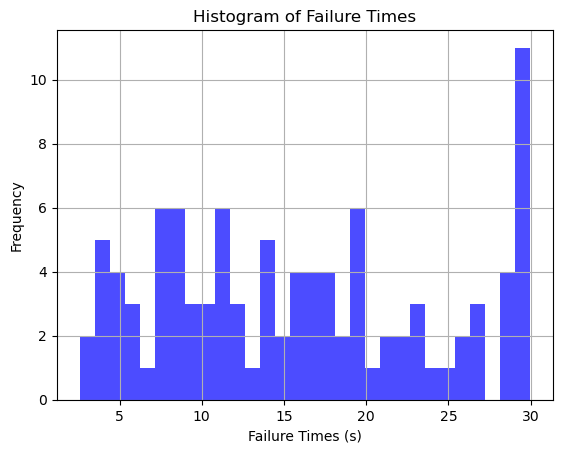

In [191]:
plt.hist(fail_time, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Failure Times')
plt.xlabel('Failure Times (s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [192]:
# This code calculates the average time of failure over the 100 simulations
avg = 0;
for i in range (0, 100):
    avg += fail_time[i]
avg / 100

The histogram gives us a clear understanding of what the distribution of the failure times look like. The average failure time still sits above the requirement since it is 15.99. This means that our controller succeeded since the average time till failure exceeded the 10 second mark. The average failure time could've been higher, but since we limited it to 30 second trials, the average was limited as well. Since we limited the trials to 30 seconds, we can't tell tell if this is normally distributed, but with longer time trials, we could make more assumptions. 

Text(0.5, 1.0, 'RMSE of Yaw Histogram')

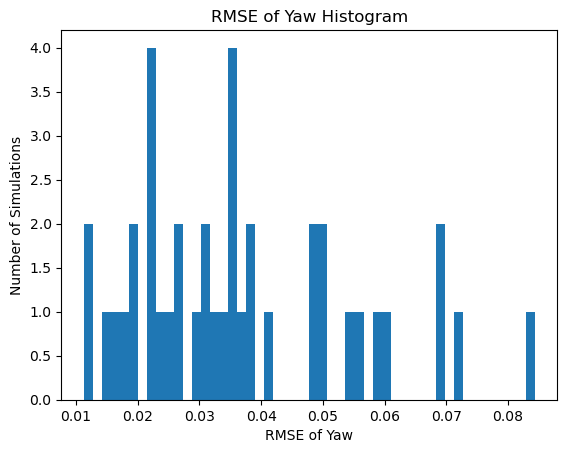

In [193]:
# plt.figure(figsize=(9, 5))
plt.hist(RMSE_psi_array,50)
plt.xlabel("RMSE of Yaw")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Yaw Histogram")

Text(0.5, 1.0, 'RMSE of Pitch Histogram')

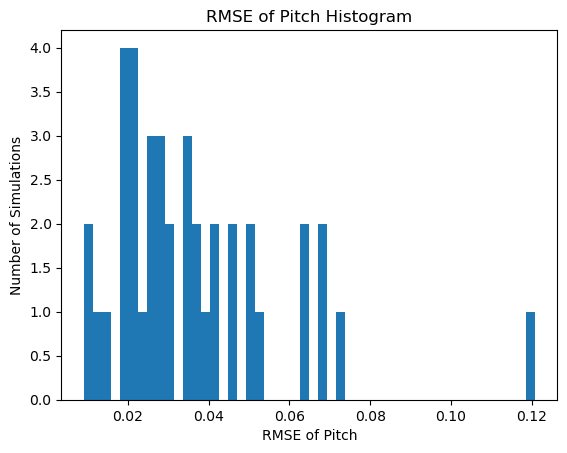

In [194]:
plt.hist(RMSE_theta_array,50)
plt.xlabel("RMSE of Pitch")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Pitch Histogram")

Text(0.5, 1.0, 'RMSE of Roll Histogram')

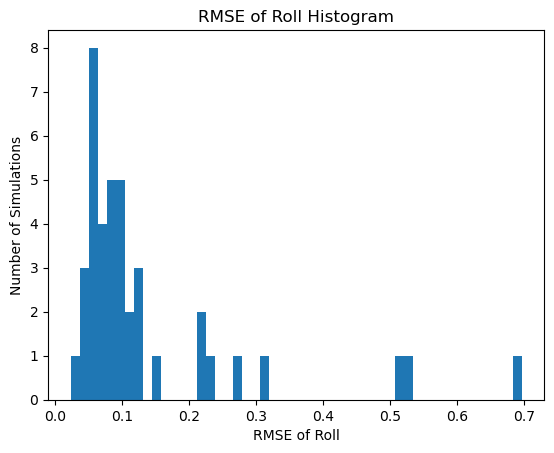

In [195]:
plt.hist(RMSE_phi_array,50)
plt.xlabel("RMSE of Roll")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Roll Histogram")

From the RMSE graphs, we can see that only 3 trials exceeded the RMSE's exceeded the limit of 0.7. Although after being hit by debris there were usually massive changes to the system, the estimated state and the actual state remained relatively close. This means our system was successful, as it fulfilled our second requirement as well. The RMSE of pitch and yaw remained relatively low, not going over 0.15, however, the roll seemed to be more inaccurate, but it still stayed below our limit for 97% of the trials. 

Overall, from the histograms dealing the failure times and the data aon the RMSE's of all the angular positions, we can see that our controller fulfilled its requirement of surpassing an average time till failure of 10 seconds by reaching an average of ___ and it stayed below its limit of ____ for all angular positions. 

## Conclusion
We were contracted to create a controller and observer for a spacecraft that has a star tracker onboard. We used state estimates and sensor measurements of the positions of pre-cataloged stars to determine the position and speed of the spacecraft. Through these estimates and measurements, we were able to apply torques to 4 different wheels which worked as momentum exchange devices to alter the rotational position of the spacecraft. Debris hitting the spacecraft at random times simulated possible disturbances in space and our controller was expected to keep the stars in view of the camera. By creating requirements around the time till failure of the simulation, the RMSE between the estimated state estimate and the actual state, and the wheel velocities, we could verify the success of the controller. For further analysis, we could adjust the initial conditions of the spacecraft so it isn't directly facing the stars, to see if it could correct itself and handle the debris. We could also implement a PID controller for better controller performance.

 

## Acknowledgements

We would like to thank Arna Bhardwaj for her help on creating our working controller and answering concerns on the report. We would also like to thank the rest of the AE353 teaching staff for helping to set up the dynamics for the spacecraft. Finally, we would like to thank Dr. Chang for giving us an extension on the report due to unforeseen circumstances on our end.

## Team Reflection
The project overall went well, we met on five separate occasions and asked Professor Chang questions when necessary.  What went well was communication, code was easily sent back and forth through Slack, and the report was split in half with each person delegated to specific pieces of the report. What might have helped our team be more productive is software that allowed both of us to write in the same jupyter notebook at the same time.

## References:
[1] Cheng, W., DP 3 Spacecraft with star tracker. Canvas, 2024
21] Cruz, J. B., and Petar V. K. Feedback Systems. New York: McGraw-Hill, 1971. pp. 265-28
0